In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines() 
# 데이터의 문장 하나하나를 줄 단위로 나누어 리스트 안에 넣는다.

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen) 
# raw[0:100][::20] - 처음부터 100번 까지의 문장 중 첫 문장부터 20의 term을 두고 할당함.

# --> 아래 결과는 1, 21, 41, 61, 81 번째의 문장 총 5개를 출력함.

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60
(377,)


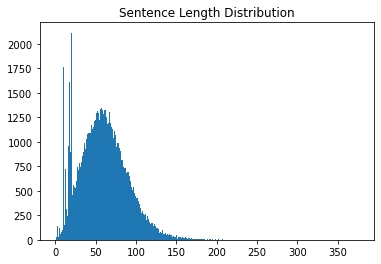

In [2]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)
print(sentence_length.shape) 
# max_len에 괄호를 씌우든 씌우지 않든 shape는 동일하다.

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


In [3]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)


’


In [4]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)


Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


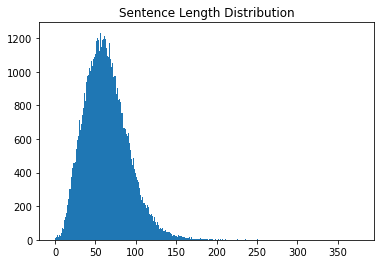

In [5]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


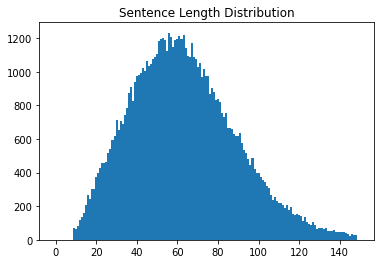

In [6]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


#### SentencePiece 모델 학습

In [7]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


In [8]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Aug 16 09:52 korean_spm.model
-rw-r--r-- 1 root root 146213 Aug 16 09:52 korean_spm.vocab


In [9]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


#### Tokenizer 함수 작성

In [10]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

### 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기¶


#### 데이터 준비와 확인

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy
import os
import sentencepiece as spm
import pandas as pd

In [12]:
import pandas as pd

train_data = pd.read_table('~/aiffel/SentencePiece/datas/ratings_train.txt')



In [13]:
train_data.head()

id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1

In [14]:
path_to_file = './datas/ratings_train.txt'
num_lines_to_read = 5

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 150001
Example:
>> id	document	label
>> 3989148	약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.	1
>> 4805788	이 영화가 왜 이렇게 저평가 받는지 모르겠다	1
>> 8317483	백봉기 언제나오나요?	1
>> 9801316	아햏햏 아햏햏 아햏햏.	1


In [15]:
with open(path_to_file, 'r', encoding='utf-8') as file:
    lines_preview = [file.readline().strip() for _ in range(num_lines_to_read)]

lines_preview

['id\tdocument\tlabel',
 '9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0',
 '3819312\t흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나\t1',
 '10265843\t너무재밓었다그래서보는것을추천한다\t0',
 '9045019\t교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정\t0']

In [16]:
sentences = []
with open(path_to_file, 'r', encoding='utf-8') as file:
    next(file)  # Skip the header line
    for line in file:
        parts = line.strip().split('\t')
        if len(parts) > 1:  # Ensure that the line has the required parts
            sentences.append(parts[1])

print("Example:")
for sen in sentences[0:100][::20]:
    print(">>", sen)

Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


#### length 설정

문장의 최단 길이: 8
문장의 최장 길이: 168
문장의 평균 길이: 45


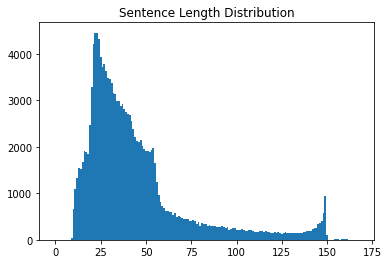

In [17]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

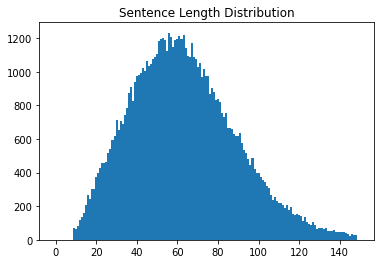

In [18]:
max_len = 150
min_len = 10

# 길이 조건에 맞추어 문장 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

#### SentencePiece를 활용해 모델 학습

In [19]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [20]:
import sentencepiece as spm
import os

train_file = './datas/ratings_train-t.txt'

with open(train_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')
        
vocab_size = 8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Aug 16 09:52 korean_spm.model
-rw-r--r-- 1 root root 146213 Aug 16 09:52 korean_spm.vocab


In [21]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

tokensIDs = s.EncodeAsIds('그영화는우리에게많은감동을주었다.')
print(tokensIDs)

print(s.SampleEncodeAsPieces('그영화는우리에게많은감동을주었다.',1, 0.0))

print(s.DecodeIds(tokensIDs))

[43, 2766, 10, 1567, 68, 5758, 382, 356, 5, 75, 266, 3]
['▁그', '영화', '는', '우리', '에게', '많은', '감', '동', '을', '주', '었다', '.']
그영화는우리에게많은감동을주었다.


In [22]:
def sp_tokenize(s, corpus): 
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
        
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, word_index, index_word

tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)

print(tensor)
print(word_index)
print(index_word)

[[  45  695  388 ...    0    0    0]
 [1371 1244    4 ...    0    0    0]
 [3553  144 2758 ...    0    0    0]
 ...
 [ 854   17  240 ...    0    0    0]
 [ 148    6  710 ...    0    0    0]
 [  25 2723 2278 ...    0    0    0]]
{'<unk>': 0, '<s>': 1, '</s>': 2, '.': 3, '▁': 4, '을': 5, '의': 6, '에': 7, '이': 8, '를': 9, '는': 10, '가': 11, '은': 12, ',': 13, '고': 14, '에서': 15, '로': 16, '한': 17, '▁“': 18, '인': 19, '”': 20, '일': 21, ')': 22, '(': 23, '과': 24, '▁이': 25, '와': 26, '으로': 27, '▁있다': 28, '지': 29, '도': 30, '▁수': 31, '할': 32, '했다': 33, '▁밝혔다': 34, '▁말했다': 35, '하고': 36, '년': 37, '다': 38, '하는': 39, '▁있는': 40, '기': 41, '리': 42, '▁그': 43, '자': 44, '▁전': 45, '며': 46, '스': 47, '해': 48, '▁2': 49, '▁그는': 50, '▁1': 51, '만': 52, '▁대한': 53, '된': 54, '▁위해': 55, '월': 56, '▁전했다': 57, '▁미국': 58, '▁한': 59, '▁미': 60, '▁3': 61, '▁이번': 62, '▁중': 63, '▁지난': 64, '현지시간': 65, '시': 66, '라': 67, '에게': 68, '나': 69, '▁대해': 70, '어': 71, '"': 72, '사': 73, 's': 74, '주': 75, '▁것으로': 76, '▁‘': 77, '트': 78, '명이': 79, 

#### KoNLPy 형태소 분석기를 사용한 모델과 성능 비교

#### KoNLPy 형태소 분석기

In [23]:
from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt

tokenizer_list = [Hannanum(),Kkma(),Komoran(),Mecab(),Okt()]

text = 'Google에서 제공하는 학습된 SentencePiece 모델의 토크나이저와 KoNLPy 형태소 분석기를 사용한 모델 중 어떤 게 더 성능이 좋은지 비교해봅시다.'

for tokenizer in tokenizer_list:
    print('[{}] \n{}'.format(tokenizer.__class__.__name__, tokenizer.pos(text)))

[Hannanum] 
[('Google', 'F'), ('에서', 'J'), ('제공', 'N'), ('하', 'X'), ('는', 'E'), ('학습', 'N'), ('되', 'X'), ('ㄴ', 'E'), ('SentencePiece', 'F'), ('모델', 'N'), ('의', 'J'), ('토크나이저', 'N'), ('와', 'J'), ('KoNLPy', 'F'), ('형태소', 'N'), ('분석기', 'N'), ('를', 'J'), ('사용', 'N'), ('하', 'X'), ('ㄴ', 'E'), ('모델', 'N'), ('중', 'N'), ('어떤', 'M'), ('것', 'N'), ('이', 'J'), ('더', 'M'), ('성능', 'N'), ('이', 'J'), ('좋', 'P'), ('은', 'E'), ('지', 'N'), ('비교', 'N'), ('하', 'X'), ('어', 'E'), ('보', 'P'), ('ㅂ시다', 'E'), ('.', 'S')]
[Kkma] 
[('Google', 'OL'), ('에서', 'JKM'), ('제공', 'NNG'), ('하', 'XSV'), ('는', 'ETD'), ('학습', 'NNG'), ('되', 'XSV'), ('ㄴ', 'ETD'), ('SentencePiece', 'OL'), ('모델', 'NNG'), ('의', 'JKG'), ('토크', 'NNG'), ('나이저', 'NNG'), ('와', 'JC'), ('KoNLPy', 'OL'), ('형태소', 'NNG'), ('분석기', 'NNG'), ('를', 'JKO'), ('사용', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('모델', 'NNG'), ('중', 'NNB'), ('어떠', 'VV'), ('ㄴ', 'ETD'), ('것', 'NNB'), ('이', 'JKS'), ('더', 'MAG'), ('성능', 'NNG'), ('이', 'JKS'), ('좋', 'VA'), ('은지', 'ECS'), ('비교', 'NNG')

#### 위의 학습된 SentencePiece

In [24]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

text = 'Google에서 제공하는 학습된 SentencePiece 모델의 토크나이저와 KoNLPy 형태소 분석기를 사용한 모델 중 어떤 게 더 성능이 좋은지 비교해봅시다.'

tokensIDs = s.EncodeAsIds(text)
print(tokensIDs)

print(s.SampleEncodeAsPieces(text,1, 0.0))

print(s.DecodeIds(tokensIDs))

[1021, 221, 221, 562, 967, 15, 4709, 2359, 1442, 54, 473, 1773, 5068, 471, 4551, 2484, 2241, 6, 821, 142, 69, 8, 536, 26, 1251, 221, 698, 940, 471, 371, 3406, 133, 2327, 849, 4408, 2241, 63, 762, 1510, 106, 372, 1602, 8, 1018, 29, 3774, 48, 7634, 66, 38, 3]
['▁G', 'o', 'o', 'g', 'le', '에서', '▁제공하는', '▁학', '습', '된', '▁S', 'ent', 'ence', 'P', 'ie', 'ce', '▁모델', '의', '▁토', '크', '나', '이', '저', '와', '▁K', 'o', 'N', 'L', 'P', 'y', '▁형태', '소', '▁분석', '기를', '▁사용한', '▁모델', '▁중', '▁어떤', '▁게', '▁더', '▁성', '능', '이', '▁좋은', '지', '▁비교', '해', '봅', '시', '다', '.']
Google에서 제공하는 학습된 SentencePiece 모델의 토크나이저와 KoNLPy 형태소 분석기를 사용한 모델 중 어떤 게 더 성능이 좋은지 비교해봅시다.


#### 정확도 비교

In [25]:
# 토큰화 정답
ground_truth_tokens = ['Google', '에서', '제공', '하', '는', '학습', '된', 'SentencePiece', '모델', '의', '토크나이저', '와', 'KoNLPy', '형태소', '분석기', '를', '사용', '한', '모델', '중', '어떤', '게', '더', '성능', '이', '좋', '은', '지', '비교', '해', '봅', '시', '다', '.']

In [26]:
# KoNLPy 토크나이저와의 비교
for tokenizer in tokenizer_list:
    tokens = [token[0] for token in tokenizer.pos(text)]
    matching_tokens = sum(1 for token in ground_truth_tokens if token in tokens)
    accuracy = matching_tokens / len(ground_truth_tokens)
    #accuracy = sum(1 for a, b in zip(tokens, ground_truth_tokens) if a == b) / len(ground_truth_tokens)
    print('[{}] Accuracy: {:.2f}%'.format(tokenizer.__class__.__name__, accuracy * 100))

[Hannanum] Accuracy: 79.41%
[Kkma] Accuracy: 67.65%
[Komoran] Accuracy: 73.53%
[Mecab] Accuracy: 82.35%
[Okt] Accuracy: 64.71%


In [27]:
# SentencePiece 토크나이저와의 비교

tokens = s.SampleEncodeAsPieces(text, 1, 0.0)

matching_tokens = sum(1 for token in ground_truth_tokens if token in tokens)
accuracy = matching_tokens / len(ground_truth_tokens)

print('[SentencePiece] Accuracy: {:.2f}%'.format(accuracy * 100))

[SentencePiece] Accuracy: 32.35%
